# Time Series Forecast: Features &rarr; Emissions (monthly resolution)

### Further tasks to be determined and evaluated:
- Different learning rates
- Different scalers
- Different batch sizes
- Visualize training in tensorboard
- Apply feature selection 
- Make decision on 'look_back' and 'horizon'

### Import libraries

In [110]:
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.layers import Dense, Flatten, InputLayer, LSTM, AveragePooling1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D

### Some useful functions

In [82]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [135]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title = plttitle)
    ax.set(ylabel = metric[0].swapcase() + metric[1:])
    ax.set(xlabel = 'Epoch')
    ax.legend(['train', 'val'], loc = 'upper right', fontsize='x-large')
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.set_xlabel('Epoch',fontsize = 18)
    ax.set_ylabel('Loss',fontsize = 18)
    ax.set_title(plttitle, fontsize=20)

### Read in input data (features) - X

In [84]:
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        continue
        #print(f"Feature not used: {i}")
        
date_first = feature_data.index[0]
date_last = feature_data.index[-1]
first_date = date_first.strftime("%m/%Y")
last_date = date_last.strftime("%m/%Y")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input data (samples, features): {feature_data.shape}")
print(f"Input data starts at: {first_date} and ends at: {last_date}")

Shape input data (samples, features): (111, 40)
Input data starts at: 01/2011 and ends at: 03/2020


### Read in target data (emissions) - y

In [85]:
emission_data = pd.read_csv('../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')

# Take only the emissions on which we have indicators
emission_data = emission_data[21*12:31*12-9] # from: 01/2011 - until: 03/2020
print(f"Shape output data (samples, emission): {emission_data.shape}")

Shape output data (samples, emission): (111,)


### Data preparation

In [86]:
def prepare_data(input_data, output_data, look_back=1, horizon=1, shuffle=False, apply_pca=False, pca_comp=10, scaler = None):
    
    dataX, dataY = [], []
    
    # Check data requirements
    if len(input_data) != len(output_data):
        raise ValueError('Input and ouput do not have same length!')
    
    # Apply PCA to data
    if apply_pca:
        pca = PCA(n_components = pca_comp)
        input_data = pca.fit_transform(input_data)
        print(f"PCA applied on feature input data - New feature input shape: {input_data.shape}")
        
    # Apply data scaler
    if scaler == None:
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'Standard':
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'MinMax':
        scaler = MinMaxScaler()
        input_data = scaler.fit_transform(input_data)
    else:
        raise ValueError('scaler variable has to be either \'Standard\' or \'MinMax\'!')           
    
    # Apply 'windowing' to data
    #for i in range(len(input_data)-look_back-horizon):
        #dataX.append(input_data[i:(i+look_back)])
        #dataY.append(output_data[(i+look_back):(i+look_back+horizon)])
    for i in range(len(input_data)-look_back+1):
        dataX.append(input_data[i:(i+look_back), :])
        dataY.append(emission_data[i+look_back:i+look_back+horizon])
    
    # Shuffle data
    if shuffle is True:
        random.seed(42)
        dataX, dataY = shuffle(dataX, dataY, random_state=42)
        
    return np.array(dataX), np.array(dataY)

### Define dataset properties

In [87]:
look_back = 12        # months to look back (input data)
horizon = 6           # months to look ahead (target data)
split_ratio = 0.75    # split ratio training / testing 
shuffle = True        # shuffle data yes / no
pca = False           # apply PCA to input data yes / no
scaler = 'Standard'   # choose data scaling method ...
                      # ... either 'Standard' or 'MinMax'

    
# Split into train and test sets according to split_ratio
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back + horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Define different neural network architectures

### Multi Layer Perceptron - MLP (vanilla)

In [88]:
def create_mlp(look_back, horizon, plot_summary = False):
    
    model = Sequential(name='MLP')
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Flatten(name='MLP_flatten'))
    model.add(Dense(256, activation='elu', name='Dense_1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='elu', name='Dense_2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='elu', name='Dense_3'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(16, activation='elu', name='Dense_4'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(horizon, activation='linear', name="MLP_final"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model             

### 1D Convolutional Neural Network - CNN (vanilla)

In [89]:
def create_cnn1D(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name='Dense_1'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model

### WaveNet (CNN like Neural Network Architecture) 
Reference: https://arxiv.org/pdf/1703.04691.pdf


In [90]:
def create_wavenet(look_back, horizon, plot_summary = False):   
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, X_train.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 
        
        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        
        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.1)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(3)(out)
    out = GlobalMaxPooling1D()(out)
    #out = Dense(32, activation='relu', name="second_last_dense_layer")(out)
    #out = Dropout(0.1)(out)
    #out = BatchNormalization()(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out, name='WaveNet')
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model 

### Long Short-Term Memory - LSTM

In [91]:
def create_lstm(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()       

    return model

### Create training and test set

In [92]:
X_train, y_train = prepare_data(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)

print("Shape of training data:")
print(f'Training data - X: {X_train.shape}')
print(f'Training data - y: {y_train.shape}')

Shape of training data:
Training data - X: (72, 12, 40)
Training data - y: (72, 6)


In [93]:
X_test, y_test = prepare_data(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

print("Shape of test data:")
print(f'Test data - X: {X_test.shape}')
print(f'Test data - y: {y_test.shape}')

Shape of test data:
Test data - X: (17, 12, 40)
Test data - y: (17, 6)


### Create an instance of every neural network architecture

In [94]:
wavenet = create_wavenet(look_back, horizon, plot_summary=True)
cnn1D = create_cnn1D(look_back, horizon, plot_summary=True)
lstm = create_lstm(look_back, horizon, plot_summary=True)
mlp = create_mlp(look_back, horizon, plot_summary=True)

Model: "WaveNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 12, 40)       0                                            
__________________________________________________________________________________________________
conv1d_100 (Conv1D)             (None, 12, 16)       656         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, 12, 32)       1056        conv1d_100[0][0]                 
__________________________________________________________________________________________________
conv1d_102 (Conv1D)             (None, 12, 32)       1056        conv1d_100[0][0]                 
____________________________________________________________________________________________

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv1D)              (None, 8, 128)            25728     
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 128)            512       
_________________________________________________________________
Conv_2 (Conv1D)              (None, 4, 64)             41024     
_________________________________________________________________
batch_normalization_32 (Batc (None, 4, 64)             256       
_________________________________________________________________
Conv_3 (Conv1D)              (None, 2, 32)             6176      
_________________________________________________________________
batch_normalization_33 (Batc (None, 2, 32)             128       
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0       

### Train model of every instance and show train history

In [95]:
# define callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)

# train models
history_wavenet = wavenet.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
history_cnn1D = cnn1D.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
history_lstm = lstm.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
history_mlp = mlp.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])


Train on 57 samples, validate on 15 samples
Epoch 1/250
57/57 [==============================] - 4s 62ms/step - loss: 4765.0498 - r2_keras: -192.0463 - val_loss: 4705.7787 - val_r2_keras: -237.2511
Epoch 2/250
57/57 [==============================] - 0s 4ms/step - loss: 4639.3331 - r2_keras: -207.6076 - val_loss: 4495.7888 - val_r2_keras: -226.4712
Epoch 3/250
57/57 [==============================] - 0s 4ms/step - loss: 4287.7249 - r2_keras: -165.4184 - val_loss: 3896.1288 - val_r2_keras: -195.8125
Epoch 4/250
57/57 [==============================] - 0s 4ms/step - loss: 3411.2578 - r2_keras: -133.5956 - val_loss: 2645.3129 - val_r2_keras: -132.5924
Epoch 5/250
57/57 [==============================] - 0s 4ms/step - loss: 1962.9659 - r2_keras: -95.9251 - val_loss: 1022.1122 - val_r2_keras: -50.6905
Epoch 6/250
57/57 [==============================] - 0s 4ms/step - loss: 503.4525 - r2_keras: -15.9084 - val_loss: 61.2831 - val_r2_keras: -1.8839
Epoch 7/250
57/57 [==========================

57/57 [==============================] - 0s 4ms/step - loss: 13.5594 - r2_keras: 0.4481 - val_loss: 14.2100 - val_r2_keras: 0.2706
Epoch 58/250
57/57 [==============================] - 0s 4ms/step - loss: 13.3226 - r2_keras: 0.4419 - val_loss: 14.6899 - val_r2_keras: 0.2629
Epoch 59/250
57/57 [==============================] - 0s 4ms/step - loss: 13.0791 - r2_keras: 0.4701 - val_loss: 13.9785 - val_r2_keras: 0.2991
Epoch 60/250
57/57 [==============================] - 0s 4ms/step - loss: 12.8933 - r2_keras: 0.4965 - val_loss: 14.8269 - val_r2_keras: 0.2613
Epoch 61/250
57/57 [==============================] - 0s 4ms/step - loss: 12.8966 - r2_keras: 0.5018 - val_loss: 13.8265 - val_r2_keras: 0.3163
Epoch 62/250
57/57 [==============================] - 0s 4ms/step - loss: 12.6842 - r2_keras: 0.4406 - val_loss: 12.7843 - val_r2_keras: 0.3583
Epoch 63/250
57/57 [==============================] - 0s 4ms/step - loss: 12.0897 - r2_keras: 0.4945 - val_loss: 13.9172 - val_r2_keras: 0.2818
Epoch

Train on 57 samples, validate on 15 samples
Epoch 1/250
57/57 [==============================] - 1s 23ms/step - loss: 4699.8870 - r2_keras: -216.6079 - val_loss: 4748.2513 - val_r2_keras: -239.6089
Epoch 2/250
57/57 [==============================] - 0s 1ms/step - loss: 4622.1620 - r2_keras: -190.0336 - val_loss: 4697.4700 - val_r2_keras: -237.1288
Epoch 3/250
57/57 [==============================] - 0s 1ms/step - loss: 4588.1010 - r2_keras: -179.3244 - val_loss: 4618.0316 - val_r2_keras: -233.1777
Epoch 4/250
57/57 [==============================] - 0s 1ms/step - loss: 4532.3639 - r2_keras: -189.3049 - val_loss: 4543.8671 - val_r2_keras: -229.4907
Epoch 5/250
57/57 [==============================] - 0s 1ms/step - loss: 4495.8859 - r2_keras: -177.1230 - val_loss: 4479.2364 - val_r2_keras: -226.2559
Epoch 6/250
57/57 [==============================] - 0s 1ms/step - loss: 4460.5728 - r2_keras: -168.0285 - val_loss: 4403.0871 - val_r2_keras: -222.4733
Epoch 7/250
57/57 [==================

Epoch 55/250
57/57 [==============================] - 0s 1ms/step - loss: 170.4166 - r2_keras: -12.1449 - val_loss: 225.8103 - val_r2_keras: -10.8018
Epoch 56/250
57/57 [==============================] - 0s 1ms/step - loss: 136.0206 - r2_keras: -11.9218 - val_loss: 222.6373 - val_r2_keras: -10.7188
Epoch 57/250
57/57 [==============================] - 0s 1ms/step - loss: 164.5689 - r2_keras: -44.4330 - val_loss: 266.7755 - val_r2_keras: -13.0042
Epoch 58/250
57/57 [==============================] - 0s 1ms/step - loss: 217.9895 - r2_keras: -10.3818 - val_loss: 379.8704 - val_r2_keras: -18.8159
Epoch 59/250
57/57 [==============================] - ETA: 0s - loss: 444.0623 - r2_keras: -14.06 - 0s 959us/step - loss: 198.0908 - r2_keras: -43.2358 - val_loss: 330.5441 - val_r2_keras: -16.2704
Epoch 60/250
57/57 [==============================] - 0s 1ms/step - loss: 179.0362 - r2_keras: -27.8256 - val_loss: 278.0805 - val_r2_keras: -13.4691
Epoch 61/250
57/57 [==============================] 

Epoch 26/250
57/57 [==============================] - 0s 1ms/step - loss: 4553.6090 - r2_keras: -194.5646 - val_loss: 4470.7199 - val_r2_keras: -225.0498
Epoch 27/250
57/57 [==============================] - 0s 1ms/step - loss: 4535.6412 - r2_keras: -208.7388 - val_loss: 4452.6015 - val_r2_keras: -224.3651
Epoch 28/250
57/57 [==============================] - 0s 1ms/step - loss: 4517.0686 - r2_keras: -186.2713 - val_loss: 4398.1934 - val_r2_keras: -221.2965
Epoch 29/250
57/57 [==============================] - 0s 1ms/step - loss: 4496.5630 - r2_keras: -196.7204 - val_loss: 4382.6252 - val_r2_keras: -219.9937
Epoch 30/250
57/57 [==============================] - 0s 1ms/step - loss: 4475.8059 - r2_keras: -204.6577 - val_loss: 4431.8062 - val_r2_keras: -223.1299
Epoch 31/250
57/57 [==============================] - 0s 1ms/step - loss: 4454.1694 - r2_keras: -169.3209 - val_loss: 4350.4085 - val_r2_keras: -218.6286
Epoch 32/250
57/57 [==============================] - 0s 1ms/step - loss: 44

57/57 [==============================] - 0s 1ms/step - loss: 1048.6623 - r2_keras: -46.6127 - val_loss: 1002.2816 - val_r2_keras: -49.7115
Epoch 133/250
57/57 [==============================] - 0s 1ms/step - loss: 1021.1194 - r2_keras: -60.3038 - val_loss: 979.6435 - val_r2_keras: -48.5429
Epoch 134/250
57/57 [==============================] - 0s 1ms/step - loss: 992.9095 - r2_keras: -36.4789 - val_loss: 945.2296 - val_r2_keras: -46.7164
Epoch 135/250
57/57 [==============================] - 0s 1ms/step - loss: 968.2825 - r2_keras: -37.6289 - val_loss: 942.7083 - val_r2_keras: -46.6637
Epoch 136/250
57/57 [==============================] - 0s 1ms/step - loss: 944.1068 - r2_keras: -36.6516 - val_loss: 891.3635 - val_r2_keras: -43.8673
Epoch 137/250
57/57 [==============================] - 0s 1ms/step - loss: 917.7000 - r2_keras: -52.2658 - val_loss: 887.7676 - val_r2_keras: -44.0108
Epoch 138/250
57/57 [==============================] - 0s 1ms/step - loss: 895.1212 - r2_keras: -36.6277 

Epoch 242/250
57/57 [==============================] - 0s 1ms/step - loss: 16.2172 - r2_keras: 0.2332 - val_loss: 8.0468 - val_r2_keras: 0.5900
Epoch 243/250
57/57 [==============================] - 0s 1ms/step - loss: 14.7374 - r2_keras: 0.3459 - val_loss: 8.4714 - val_r2_keras: 0.5658
Epoch 244/250
57/57 [==============================] - 0s 1ms/step - loss: 14.0984 - r2_keras: 0.3417 - val_loss: 7.0698 - val_r2_keras: 0.6280
Epoch 245/250
57/57 [==============================] - 0s 1ms/step - loss: 13.7405 - r2_keras: 0.2794 - val_loss: 7.7613 - val_r2_keras: 0.5981
Epoch 246/250
57/57 [==============================] - 0s 1ms/step - loss: 13.7101 - r2_keras: 0.2291 - val_loss: 7.3485 - val_r2_keras: 0.6287
Epoch 247/250
57/57 [==============================] - 0s 1ms/step - loss: 12.0208 - r2_keras: -0.5058 - val_loss: 6.8597 - val_r2_keras: 0.6569
Epoch 248/250
57/57 [==============================] - 0s 1ms/step - loss: 13.4414 - r2_keras: 0.2719 - val_loss: 5.7725 - val_r2_keras

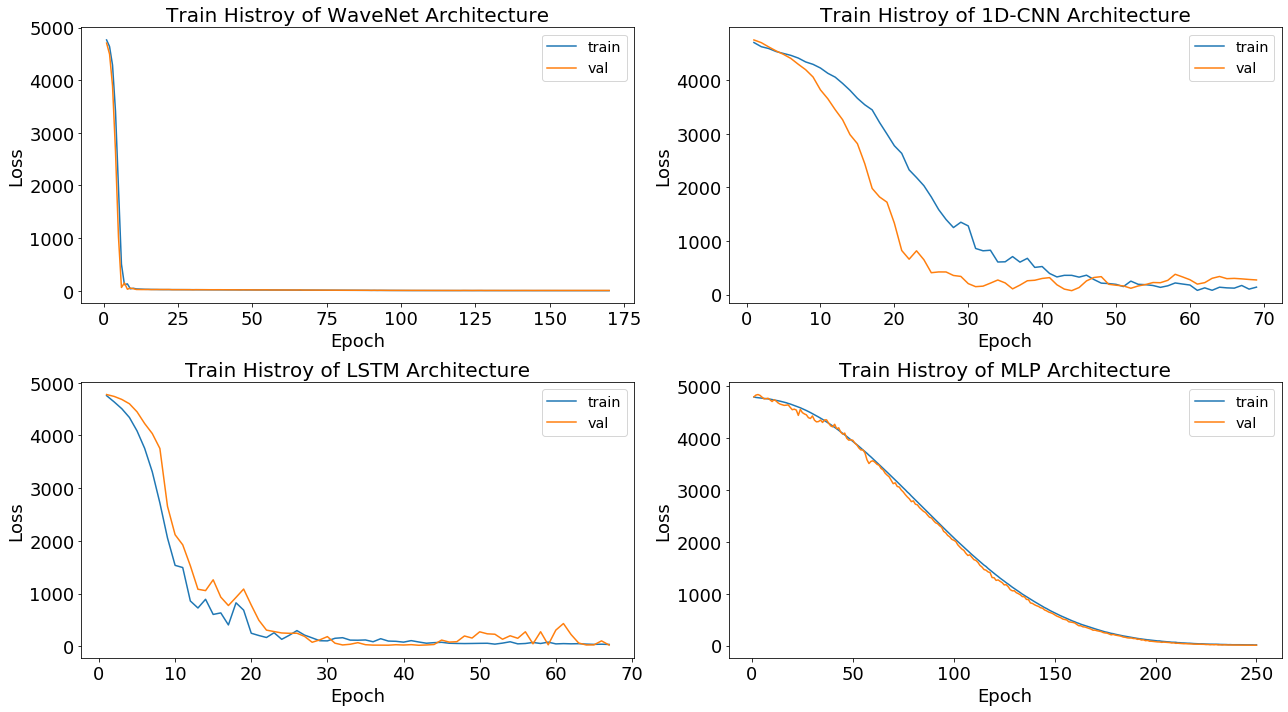

In [136]:
# plot training history for every model
fig, ax = plt.subplots(2, 2, figsize=(18,10))
plot_model_history(history_wavenet, ax = ax[0,0], plttitle='Train Histroy of WaveNet Architecture')
plot_model_history(history_cnn1D, ax = ax[0,1], plttitle='Train Histroy of 1D-CNN Architecture')
plot_model_history(history_lstm, ax = ax[1,0], plttitle='Train Histroy of LSTM Architecture')
plot_model_history(history_mlp, ax = ax[1,1], plttitle='Train Histroy of MLP Architecture')
plt.tight_layout()

### Evaluate performance of models

WaveNet Train Score: 2.02 MSE (1.42 RMSE)
WaveNet Test Score: 24.66 MSE (4.97 RMSE)
1D-CNN Train Score: 179.79 MSE (13.41 RMSE)
1D-CNN Test Score: 295.06 MSE (17.18 RMSE)
LSTM Train Score: 30.41 MSE (5.51 RMSE)
LSTM Test Score: 168.11 MSE (12.97 RMSE)
MLP Train Score: 7.32 MSE (2.71 RMSE)
MLP Test Score: 21.42 MSE (4.63 RMSE)


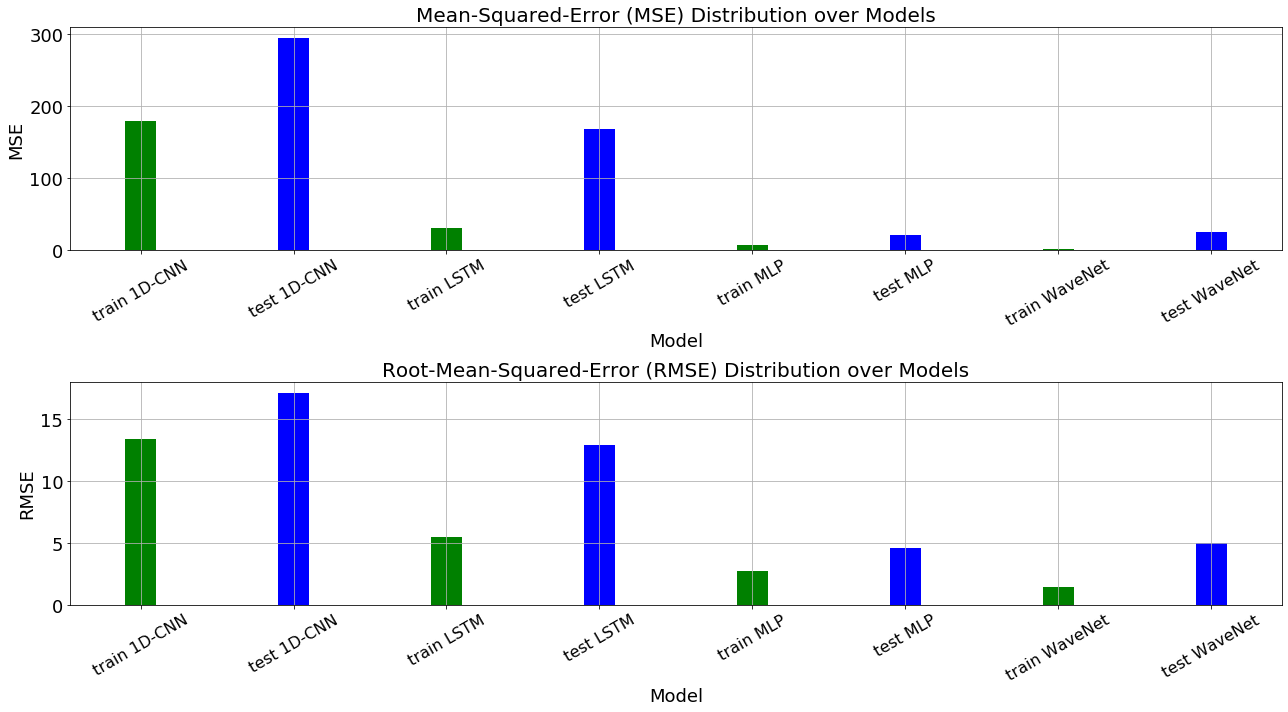

In [121]:
# WaveNet
trainScore_wavenet = wavenet.evaluate(X_train, y_train, verbose=0)
print('WaveNet Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_wavenet[0], math.sqrt(trainScore_wavenet[0])))
testScore_wavenet = wavenet.evaluate(X_test, y_test, verbose=0)
print('WaveNet Test Score: %.2f MSE (%.2f RMSE)' % (testScore_wavenet[0], math.sqrt(testScore_wavenet[0])))

# 1D-CNN
trainScore_cnn1D = cnn1D.evaluate(X_train, y_train, verbose=0)
print('1D-CNN Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_cnn1D[0], math.sqrt(trainScore_cnn1D[0])))
testScore_cnn1D = cnn1D.evaluate(X_test, y_test, verbose=0)
print('1D-CNN Test Score: %.2f MSE (%.2f RMSE)' % (testScore_cnn1D[0], math.sqrt(testScore_cnn1D[0])))

# LSTM
trainScore_lstm = lstm.evaluate(X_train, y_train, verbose=0)
print('LSTM Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_lstm[0], math.sqrt(trainScore_lstm[0])))
testScore_lstm = lstm.evaluate(X_test, y_test, verbose=0)
print('LSTM Test Score: %.2f MSE (%.2f RMSE)' % (testScore_lstm[0], math.sqrt(testScore_lstm[0])))

# MLP
trainScore_mlp = mlp.evaluate(X_train, y_train, verbose=0)
print('MLP Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_mlp[0], math.sqrt(trainScore_mlp[0])))
testScore_mlp = mlp.evaluate(X_test, y_test, verbose=0)
print('MLP Test Score: %.2f MSE (%.2f RMSE)' % (testScore_mlp[0], math.sqrt(testScore_mlp[0])))

# Plot Errorbars (MSE & RMSE) for train and test
#fig, ax = plt.subplots(2, 2, figsize=(18,10), sharey='row')
fig, ax = plt.subplots(2, figsize=(18,10))

ax[0].bar([1,2,3,4,5,6,7,8], [trainScore_cnn1D[0], testScore_cnn1D[0], trainScore_lstm[0], testScore_lstm[0], trainScore_mlp[0], testScore_mlp[0], trainScore_wavenet[0], testScore_wavenet[0]], width=0.2, color=['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue'])
ax[0].set_title('Mean-Squared-Error (MSE) Distribution over Models', fontsize=20)
ax[0].set_xlabel('Model', fontsize=18)
ax[0].set_ylabel('MSE', fontsize=18)
ax[0].set_xticks(np.arange(1,9))
ax[0].set_xticklabels(['train 1D-CNN', 'test 1D-CNN', 'train LSTM', 'test LSTM', 'train MLP', 'test MLP', 'train WaveNet', 'test WaveNet'], rotation=30, fontsize=16)
ax[0].yaxis.set_tick_params(labelsize=18)
ax[0].grid()

ax[1].bar([1,2,3,4,5,6,7,8], [math.sqrt(trainScore_cnn1D[0]), math.sqrt(testScore_cnn1D[0]), math.sqrt(trainScore_lstm[0]), math.sqrt(testScore_lstm[0]), math.sqrt(trainScore_mlp[0]), math.sqrt(testScore_mlp[0]), math.sqrt(trainScore_wavenet[0]), math.sqrt(testScore_wavenet[0])], width=0.2, color=['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue'])
ax[1].set_title('Root-Mean-Squared-Error (RMSE) Distribution over Models', fontsize=20)
ax[1].set_xlabel('Model', fontsize=18)
ax[1].set_ylabel('RMSE', fontsize=18)
ax[1].set_xticks(np.arange(1,9))
ax[1].set_xticklabels(['train 1D-CNN', 'test 1D-CNN', 'train LSTM', 'test LSTM', 'train MLP', 'test MLP', 'train WaveNet', 'test WaveNet'], rotation=30, fontsize=16)
ax[1].yaxis.set_tick_params(labelsize=18)
ax[1].grid()

plt.tight_layout()

### Model prediction

In [98]:
# Select latest possible input data
X_predict = np.zeros((1, look_back, X_train.shape[2]))
X_predict[0] = feature_data[len(feature_data)-look_back:, :]

In [99]:
# WaveNet
trainPredict_wavenet = wavenet.predict(X_train)
testPredict_wavenet = wavenet.predict(X_test)
prediction_wavenet = wavenet.predict(X_predict)
print(f"WaveNet forecast for the next {horizon} months: {np.around(prediction_wavenet, 1)} (mio. tonnes CO2)")

# 1D-CNN
trainPredict_cnn1D = cnn1D.predict(X_train)
testPredict_cnn1D = cnn1D.predict(X_test)
prediction_cnn1D = cnn1D.predict(X_predict)
print(f"1D-CNN forecast for the next {horizon} months: {np.around(prediction_cnn1D, 1)} (mio. tonnes CO2)")

# LSTM
trainPredict_lstm = lstm.predict(X_train)
testPredict_lstm = lstm.predict(X_test)
prediction_lstm = lstm.predict(X_predict)
print(f"LSTM forecast for the next {horizon} months: {np.around(prediction_lstm, 1)} (mio. tonnes CO2)")

# MLP
trainPredict_mlp = mlp.predict(X_train)
testPredict_mlp = mlp.predict(X_test)
prediction_mlp = mlp.predict(X_predict)
print(f"MLP forecast for the next {horizon} months: {np.around(prediction_mlp, 1)} (mio. tonnes CO2)")

WaveNet forecast for the next 6 months: [[78.5 77.4 77.6 73.6 72.8 72.5]] (mio. tonnes CO2)
1D-CNN forecast for the next 6 months: [[2.2986274e+08 2.1570544e+08 2.4471274e+08 1.8951152e+08 1.3924749e+08
  2.2801045e+08]] (mio. tonnes CO2)
LSTM forecast for the next 6 months: [[55.3 52.4 55.8 56.8 55.6 54.7]] (mio. tonnes CO2)
MLP forecast for the next 6 months: [[-1.00841894e+09 -1.13598720e+09 -1.02690419e+09 -1.07991501e+09
  -1.15784845e+09 -1.04512832e+09]] (mio. tonnes CO2)


In [100]:
# Shift predictions accordingly for plotting purposes

train_pad = np.zeros(look_back)
train_pad[:] = np.NaN
test_pad = np.zeros(train_size+look_back)
test_pad[:] = np.NaN
pred_pad = np.zeros(len(feature_data))
pred_pad[:] = np.NaN

# WaveNet
trainPredict_wavenet = np.concatenate((train_pad, trainPredict_wavenet[:,0]))
testPredict_wavenet = np.concatenate((test_pad, testPredict_wavenet[:,0]))
prediction_wavenet = np.concatenate((pred_pad, prediction_wavenet.reshape(-1)))

# 1D-CNN
trainPredict_cnn1D = np.concatenate((train_pad, trainPredict_cnn1D[:,0]))
testPredict_cnn1D = np.concatenate((test_pad, testPredict_cnn1D[:,0]))
prediction_cnn1D = np.concatenate((pred_pad, prediction_cnn1D.reshape(-1)))

# LSTM
trainPredict_lstm = np.concatenate((train_pad, trainPredict_lstm[:,0]))
testPredict_lstm = np.concatenate((test_pad, testPredict_lstm[:,0]))
prediction_lstm = np.concatenate((pred_pad, prediction_lstm.reshape(-1)))

# MLP
trainPredict_mlp = np.concatenate((train_pad, trainPredict_mlp[:,0]))
testPredict_mlp = np.concatenate((test_pad, testPredict_mlp[:,0]))
prediction_mlp = np.concatenate((pred_pad, prediction_mlp.reshape(-1)))

### Plot results

In [101]:
# Create time scope (x-axis) for final plot

time_scope = []
for i in np.arange(int(first_date.split('/')[1]), int(last_date.split('/')[1])+1):
    for j in np.arange(1,13):
        time_scope.append(str(j)+"/"+str(i))

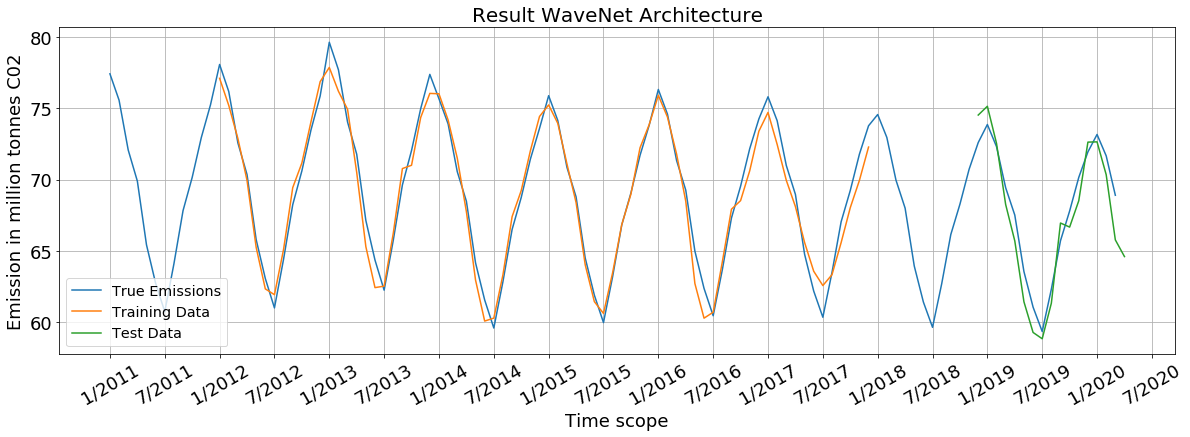

In [165]:
# WaveNet resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_wavenet, label='Training Data')
plt.plot(testPredict_wavenet, label='Test Data')
#plt.plot(prediction_wavenet, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result WaveNet Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

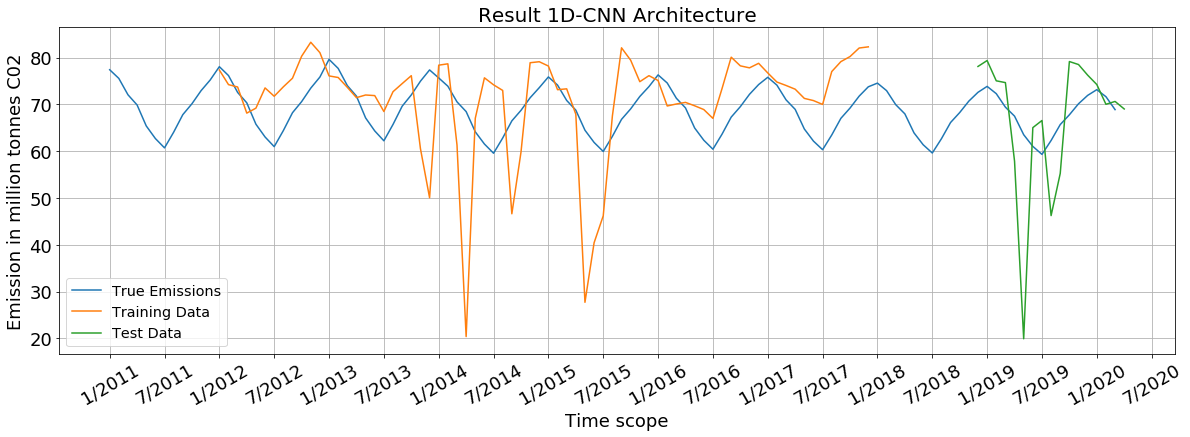

In [166]:
# 1D-CNN resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_cnn1D, label='Training Data')
plt.plot(testPredict_cnn1D, label='Test Data')
#plt.plot(prediction_cnn1D, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result 1D-CNN Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

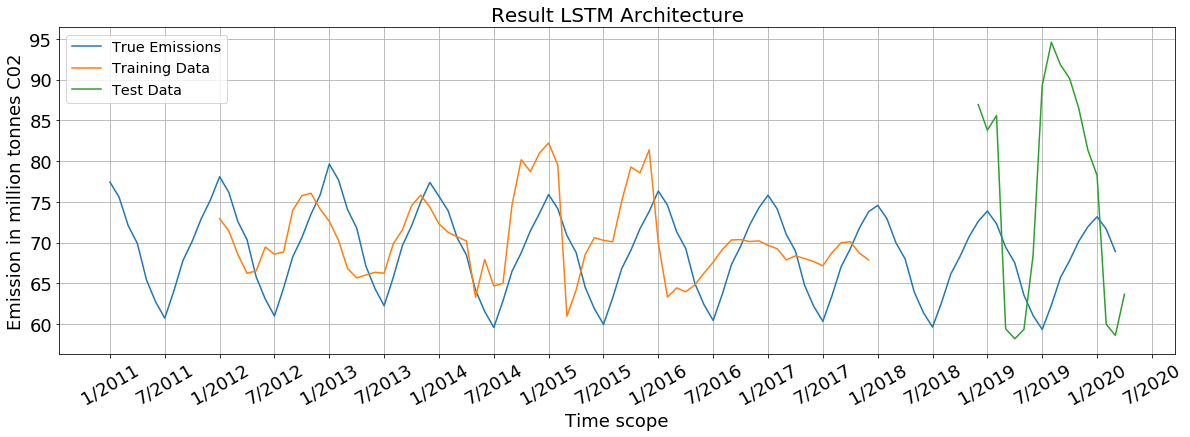

In [167]:
# LSTM resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_lstm, label='Training Data')
plt.plot(testPredict_lstm, label='Test Data')
#plt.plot(prediction_lstm, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result LSTM Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='upper left')
plt.grid()
plt.show()

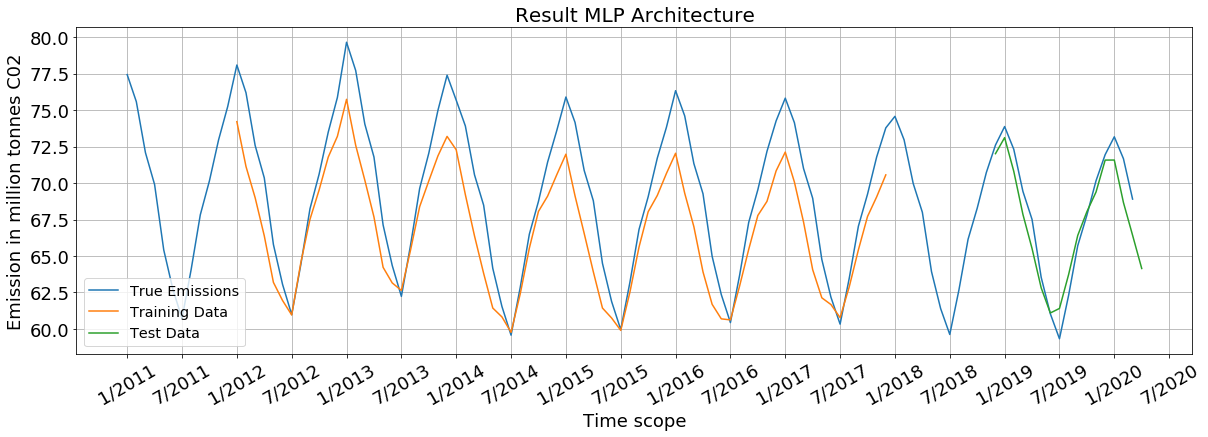

In [169]:
# MLP resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_mlp, label='Training Data')
plt.plot(testPredict_mlp, label='Test Data')
#plt.plot(prediction_mlp, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result MLP Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()